# BMO Exploratory Data Analysis

In [88]:
import gcp
import gcp.bigquery as bq

## Unique use cases and counts

In [89]:
%%sql --module unique_use_cases_and_counts
SELECT
  USE_CASE AS use_case,
  COUNT(USE_CASE) AS num_instances
FROM
  [CreditCardv2.cc_trans_02052016]
GROUP BY
  use_case
ORDER BY
  use_case ASC

In [90]:
%bigquery execute --query unique_use_cases_and_counts

use_case,num_instances
Use Case 1.0 - Green,149545111
Use Case 1.0 - Red,9193267
Use Case 1.0 - Yellow,16023426
Use Case 1.1 - Green,149418045
Use Case 1.1 - Red,9218987
Use Case 1.1 - Yellow,16168827
Use Case 10 - Green,149255636
Use Case 10 - Red,9257698
Use Case 10 - Yellow,16066959
Use Case 11 - Green,149360630


In [91]:
%%chart columns -d unique_use_cases_and_counts
height: 500
width: 1000

## Use case 1

### Overpayments and Refunds to credit card balances

Scenario Description

This scenario purports to detect AML risks in which a money launderer may be using dirty money to overpay credit card balance and get a refund of clean money from the credit card issuer.  Overpayment = (Payment made) > (Payment Owed)

In the example below, there are two overpayments that resulted in negative balance that’d be refunded to the customer (e.g. in 90 days).

|Transaction Date|Transaction Type|Transaction Amount ($)|Credit Card Balance|
|---|---|---|---|
|1/1/15|Purchase|100|100|
|1/15/15|Purchase|100|200|
|1/23/15|Purchase|100|300|
|1/31/15|Payment|-600|-300 (to be refunded to customer)|
|2/10/15|Purchase|100|-200|
|2/19/15|Purchase|200|0|
|2/25/15|Purchase|300|300|
|2/28/15|Payment|-700|-400 (to be refunded to customer)|

This use case is subdivided into two: Overpayments and refund.  An overpayment is a situation where an overpayment is made then subsequently the customer uses the credit card to remove the negative balance.  A refund is a situation where an overpayment is made and subsequently money is actually refunded to the customer.

#### 1.0 Threshold for Overpayment

* Red where # of overpayments is 70% or greater in the # of months in the time period covered by the transaction data (e.g. 7 overpayments in a 10-month period)
* Yellow where # of overpayments is between 30% and 70%.
* Green where # of overpayments is below 30%.

#### 1.1 Threshold for Refunds

* Red where # of Refunds is 50% or greater in the # of months in the time period covered by the transaction data (e.g. 5 refunds in a 10-month period)
* Yellow where # of overpayments is between 25% and 50%.
* Green where # of overpayments is below 25%.

In [92]:
%%sql --module use_case_1_point_0

DEFINE QUERY total_number
  SELECT
    COUNT(*) as total_number
  FROM
    [CreditCardv2.cc_trans_02052016]
  WHERE
    REGEXP_MATCH(USE_CASE, 'Use Case 1.0')

DEFINE QUERY sample_all_fields
  SELECT
    *
  FROM
    [CreditCardv2.cc_trans_02052016]
  WHERE
    REGEXP_MATCH(USE_CASE, 'Use Case 1.0')
  ORDER BY
    USE_CASE, ACCOUNTID, ROWNUM
  LIMIT
    50

DEFINE QUERY num_use_case_by_account
  SELECT
    ACCOUNTID AS account_id,
    USE_CASE AS use_case,
    COUNT(USE_CASE) AS num_use_case
  FROM
    [CreditCardv2.cc_trans_02052016]
  WHERE
    REGEXP_MATCH(USE_CASE, 'Use Case 1.0')
  GROUP BY
    account_id,
    use_case
  ORDER BY
    account_id,
    use_case

DEFINE QUERY all_fields_100000043_green
  SELECT
    *
  FROM
    [CreditCardv2.cc_trans_02052016]
  WHERE
    ACCOUNTID = '100000043'
  ORDER BY
    TRANSACTION_DATE,
    POST_DATE

DEFINE QUERY all_fields_100001734_yellow
  SELECT
    *
  FROM
    [CreditCardv2.cc_trans_02052016]
  WHERE
    ACCOUNTID = '100001734'
  ORDER BY
    TRANSACTION_DATE,
    POST_DATE

DEFINE QUERY all_fields_100000059_red
  SELECT
    *
  FROM
    [CreditCardv2.cc_trans_02052016]
  WHERE
    ACCOUNTID = '100000059'
  ORDER BY
    TRANSACTION_DATE,
    POST_DATE

In [93]:
%bigquery execute --query use_case_1_point_0.total_number

total_number
174761804


In [94]:
%bigquery execute --query use_case_1_point_0.sample_all_fields

ROWNUM,ACCOUNTID,MERCHANT_NAME,MERCHANT_CATEGORY_CODE,MERCHANT_CATEGORY_DESC,MERCHANT_COUNTRY,POST_DATE,TRANSACTION_DATE,TRANSACTION_TYPE,CREDIT_DEBIT,CREDIT_LIMIT,AMOUNT,BALANCE,CREDITCARDNUMBER,CC_TYPE,USE_CASE,CUST_NAME,NUM_CCS,CUST_CITY,CUST_STATE,CUST_ZIP,CUST_COUNTRY,TRANS_DETAIL
0_2016-02-04 17:45:21,100000043,Hill Hardware,3389,Car Rental,US,2015-01-03,2015-01-02,Purchase,D,18000,4004,13996,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
100_2016-02-04 17:45:21,100000043,West People Resource,3644,Hotels/Motels/Inns/Resorts,US,2015-07-18,2015-07-17,Purchase,D,18000,80,319,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
101_2016-02-04 17:45:21,100000043,General Resource Frontier,3555,Hotels/Motels/Inns/Resorts,US,2015-07-19,2015-07-18,Purchase,D,18000,237,82,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
102_2016-02-04 17:45:21,100000043,Design Electronic Consulting,5192,Books Periodicals and Newspapers,US,2015-07-21,2015-07-20,Purchase,D,18000,64,18,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
103_2016-02-04 17:45:21,100000043,,1111,Customer Payment,US,2015-07-24,2015-07-23,e-Check,C,18000,8,26,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
104_2016-02-04 17:45:21,100000043,Electronics Innovation Systems,5999,Miscellaneous Specialty Retail,US,2015-07-26,2015-07-25,Purchase,D,18000,17,9,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
105_2016-02-04 17:45:21,100000043,Provider Atlantic Software,3109,Airlines,US,2015-07-29,2015-07-28,Purchase,D,18000,8,1,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
106_2016-02-04 17:45:21,100000043,Future Venture,3562,Hotels/Motels/Inns/Resorts,US,2015-07-31,2015-07-30,Penalty,D,18000,1,0,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
107_2016-02-04 17:45:21,100000043,,1111,Customer Payment,US,2015-08-01,2015-07-31,Payment,C,18000,8490,8490,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
108_2016-02-04 17:45:21,100000043,,1111,Customer Payment,US,2015-08-03,2015-08-02,Online Transfer,C,18000,1105,9595,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,


In [95]:
%bigquery execute --query use_case_1_point_0.num_use_case_by_account

account_id,use_case,num_use_case
100000043,Use Case 1.0 - Green,115
100000059,Use Case 1.0 - Red,122
100000340,Use Case 1.0 - Green,142
100000510,Use Case 1.0 - Green,133
100000527,Use Case 1.0 - Green,113
100000639,Use Case 1.0 - Green,137
100000724,Use Case 1.0 - Green,136
100000918,Use Case 1.0 - Green,111
100000931,Use Case 1.0 - Green,129
100000967,Use Case 1.0 - Green,134


In [96]:
%bigquery execute --query use_case_1_point_0.all_fields_100000043_green

ROWNUM,ACCOUNTID,MERCHANT_NAME,MERCHANT_CATEGORY_CODE,MERCHANT_CATEGORY_DESC,MERCHANT_COUNTRY,POST_DATE,TRANSACTION_DATE,TRANSACTION_TYPE,CREDIT_DEBIT,CREDIT_LIMIT,AMOUNT,BALANCE,CREDITCARDNUMBER,CC_TYPE,USE_CASE,CUST_NAME,NUM_CCS,CUST_CITY,CUST_STATE,CUST_ZIP,CUST_COUNTRY,TRANS_DETAIL
0_2016-02-04 17:45:21,100000043,Hill Hardware,3389,Car Rental,US,2015-01-03,2015-01-02,Purchase,D,18000,4004,13996,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
1_2016-02-04 17:45:21,100000043,Universal Net Architecture,4457,Boat Rentals and Leases,US,2015-01-06,2015-01-05,Purchase,D,18000,6246,7750,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
2_2016-02-04 17:45:21,100000043,,1111,Customer Payment,US,2015-01-08,2015-01-07,Online Transfer,C,18000,4452,12202,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
3_2016-02-04 17:45:21,100000043,Source Electronics,8249,Vocational/Trade Schools,US,2015-01-10,2015-01-09,Purchase,D,18000,673,11529,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
4_2016-02-04 17:45:21,100000043,Future Systems Power,3045,Airlines,US,2015-01-12,2015-01-11,Fee,D,18000,10724,805,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
5_2016-02-04 17:45:21,100000043,,1111,Customer Payment,US,2015-01-14,2015-01-13,ACH Payment,C,18000,451,1256,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
6_2016-02-04 17:45:21,100000043,,1111,Customer Payment,US,2015-01-16,2015-01-15,ACH Payment,C,18000,285,1541,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
7_2016-02-04 17:45:21,100000043,Data Application,3076,Airlines,US,2015-01-18,2015-01-17,Purchase,D,18000,199,1342,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
8_2016-02-04 17:45:21,100000043,Internet Resource,3088,Airlines,US,2015-01-21,2015-01-20,Purchase,D,18000,296,1046,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,
9_2016-02-04 17:45:21,100000043,Alpha Power Research,3223,Airlines,US,2015-01-23,2015-01-22,Interest Charge,D,18000,304,742,96962345145096358,visa,Use Case 1.0 - Green,Keshia Turner,1,RANCHO CORDOVA,CA,95670,US,


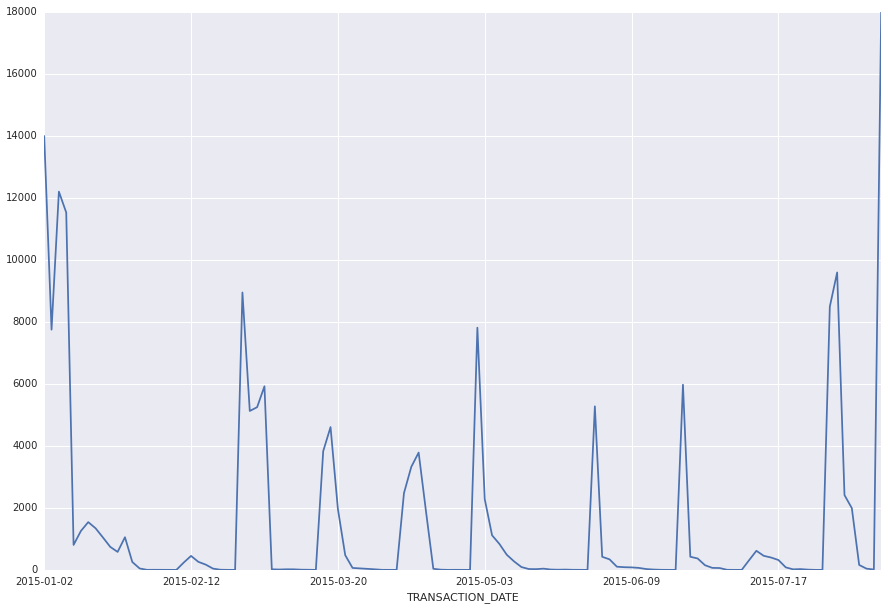

In [97]:
all_fields_100000043_green = bq.Query(use_case_1_point_0.all_fields_100000043_green).to_dataframe().set_index('TRANSACTION_DATE')
_ = all_fields_100000043_green['BALANCE'].astype('float').plot(figsize=(15,10))

In [98]:
%bigquery execute --query use_case_1_point_0.all_fields_100001734_yellow

ROWNUM,ACCOUNTID,MERCHANT_NAME,MERCHANT_CATEGORY_CODE,MERCHANT_CATEGORY_DESC,MERCHANT_COUNTRY,POST_DATE,TRANSACTION_DATE,TRANSACTION_TYPE,CREDIT_DEBIT,CREDIT_LIMIT,AMOUNT,BALANCE,CREDITCARDNUMBER,CC_TYPE,USE_CASE,CUST_NAME,NUM_CCS,CUST_CITY,CUST_STATE,CUST_ZIP,CUST_COUNTRY,TRANS_DETAIL
0_2016-02-04 17:45:23,100001734,Construction Star Architecture,3553,Hotels/Motels/Inns/Resorts,US,2015-01-04,2015-01-03,Purchase,D,24000,5227,18773,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
1_2016-02-04 17:45:23,100001734,Vision Alpha,3740,Hotels/Motels/Inns/Resorts,US,2015-01-05,2015-01-04,Interest Charge,D,24000,4743,14030,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
2_2016-02-04 17:45:23,100001734,Resource Construction Max,5044,Photographic Photocopy Microfilm Equipment and Supplies,US,2015-01-07,2015-01-06,Purchase,D,24000,5976,8054,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
3_2016-02-04 17:45:23,100001734,People Consulting Interactive,3590,Hotels/Motels/Inns/Resorts,US,2015-01-09,2015-01-08,Penalty,D,24000,3698,4356,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
4_2016-02-04 17:45:23,100001734,,1111,Customer Payment,US,2015-01-12,2015-01-11,Cash Payment,C,24000,2435,6791,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
5_2016-02-04 17:45:23,100001734,,1111,Customer Payment,US,2015-01-14,2015-01-13,Online Transfer,C,24000,1021,7812,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
6_2016-02-04 17:45:23,100001734,Design Solutions Innovation,3155,Airlines,US,2015-01-16,2015-01-15,Purchase,D,24000,3027,4785,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
7_2016-02-04 17:45:23,100001734,,1111,Customer Payment,US,2015-01-18,2015-01-17,Award,C,24000,3896,8681,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
8_2016-02-04 17:45:23,100001734,Max Digital,3396,Car Rental,US,2015-01-20,2015-01-19,Purchase,D,24000,2382,6299,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,
9_2016-02-04 17:45:23,100001734,,1111,Customer Payment,US,2015-01-21,2015-01-20,Online Transfer,C,24000,745,7044,79832345145912425,mastercard,Use Case 1.0 - Yellow,Issac Green,2,PANORAMA CITY,CA,91402,US,


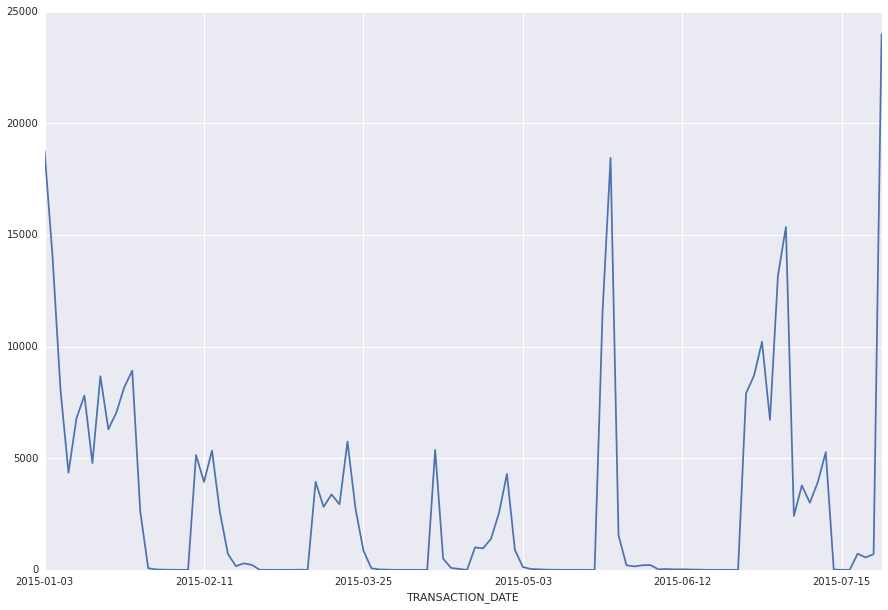

In [99]:
all_fields_100001734_yellow = bq.Query(use_case_1_point_0.all_fields_100001734_yellow).to_dataframe().set_index('TRANSACTION_DATE')
_ = all_fields_100001734_yellow['BALANCE'].astype('float').plot(figsize=(15,10))

In [100]:
%bigquery execute --query use_case_1_point_0.all_fields_100000059_red

ROWNUM,ACCOUNTID,MERCHANT_NAME,MERCHANT_CATEGORY_CODE,MERCHANT_CATEGORY_DESC,MERCHANT_COUNTRY,POST_DATE,TRANSACTION_DATE,TRANSACTION_TYPE,CREDIT_DEBIT,CREDIT_LIMIT,AMOUNT,BALANCE,CREDITCARDNUMBER,CC_TYPE,USE_CASE,CUST_NAME,NUM_CCS,CUST_CITY,CUST_STATE,CUST_ZIP,CUST_COUNTRY,TRANS_DETAIL
0_2016-02-04 17:45:21,100000059,Virtual Power Omega,3271,Airlines,US,2015-01-03,2015-01-02,Fee,D,3000,2049,951,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
1_2016-02-04 17:45:21,100000059,,1111,Customer Payment,US,2015-01-04,2015-01-03,Cash Payment,C,3000,465,1416,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
2_2016-02-04 17:45:21,100000059,Resource Speed Star,8244,Business/Secretarial Schools,US,2015-01-05,2015-01-04,Fee,D,3000,318,1098,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
3_2016-02-04 17:45:21,100000059,,1111,Customer Payment,US,2015-01-07,2015-01-06,Wire Payment,C,3000,170,1268,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
4_2016-02-04 17:45:21,100000059,People Net Speed,5499,Miscellaneous Food Stores Convenience Stores and Specialty Markets,US,2015-01-10,2015-01-09,Refund,D,3000,775,493,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
5_2016-02-04 17:45:21,100000059,Adventure Consulting,3072,Airlines,US,2015-01-13,2015-01-12,Fee,D,3000,424,69,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
6_2016-02-04 17:45:21,100000059,,1111,Customer Payment,US,2015-01-15,2015-01-14,ATM Payment,C,3000,42,111,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
7_2016-02-04 17:45:21,100000059,,1111,Customer Payment,US,2015-01-17,2015-01-16,Paper Check,C,3000,74,185,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
8_2016-02-04 17:45:21,100000059,,1111,Customer Payment,US,2015-01-20,2015-01-19,Cash Payment,C,3000,91,276,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,
9_2016-02-04 17:45:21,100000059,,1111,Customer Payment,US,2015-01-22,2015-01-21,Award,C,3000,227,503,22482345145093979,discover,Use Case 1.0 - Red,Author Jacobson PhD,2,SAN ANTONIO,TX,78223,US,


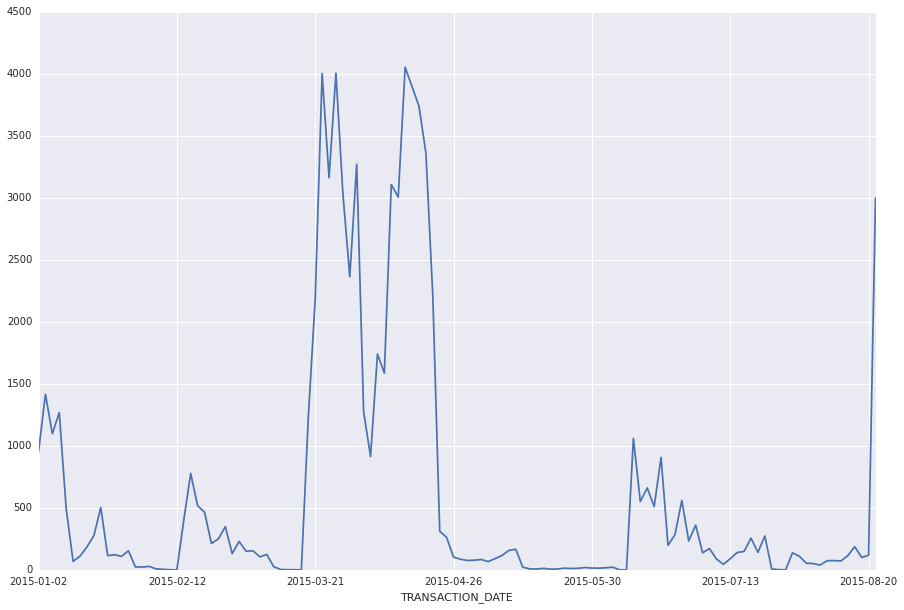

In [101]:
all_fields_100000059_red = bq.Query(use_case_1_point_0.all_fields_100000059_red).to_dataframe().set_index('TRANSACTION_DATE')
_ = all_fields_100000059_red['BALANCE'].astype('float').plot(figsize=(15,10))